In [115]:
!pip install pyBKT

In [116]:
import json
import math
import csv
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from datetime import datetime
import sklearn
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score

In [117]:
# Load csv file
dataEvents = pd.read_csv('C:\\Users\\struk\\Downloads\\Knowledge Inference & Adaptive Learning\\paper\\anonamyze_all_data_collection.csv', sep=";")

In [118]:
# Name and number of the columns of the input file
student_id = 'user'
timestamp = 'initial timestamp'
student_column_number = 1
group_column_number = 0
completed = 'n_completed'
puzzle_name = 'task_id'
puzzle_column_number = 2
kc_column = 'kc'
kc_column_number = 4

# Different Knowledge components
kcs = ['GMD.4', 'CO.5', 'CO.6', 'MG.1', 'MIX']

# Puzzle by KC
mg1Puzzles = ['Bird Fez', 'Pi Henge', 'Bull Market']
gmd4Puzzles = ['Angled Silhouette', 'Not Bird', 'Stranger Shapes', 'Few Clues']
co5Puzzles = ['45-Degree Rotations', 'Boxes Obscure Spheres', 'More Than Meets Your Eye']
co6Puzzles = ['Tall and Small', 'Ramp Up and Can It', '6. Stretch a Ramp', '7. Max 2 Boxes']
mixPuzzles = ['1. One Box', '2. Separated Boxes', '3. Rotate a Pyramid', '4. Match Silhouettes', '5. Removing Objects', '8. Combine 2 Ramps', '9. Scaling Round Objects', 'Square Cross-Sections', 'Pyramids are Strange', 'Object Limits', 'Square Cross-Sections', 'Pyramids are Strange', 'Object Limits', 'Tetromino', 'Warm Up', 'Sugar Cones', 'Unnecessary', 'Zzz', 'Orange Dance', 'Bear Market']

In [119]:
dataEvents2 = dataEvents.copy()
dataEvents2['time'] = pd.to_datetime(dataEvents['time'])
dataEvents2 = dataEvents2.sort_values('time')

#iterates in the groups and users of the data
dataEvents2['group'] = [json.loads(x)['group'] if 'group' in json.loads(x).keys() else '' for x in dataEvents2['data']]
dataEvents2['user'] = [json.loads(x)['user'] if 'user' in json.loads(x).keys() else '' for x in dataEvents2['data']]
dataEvents2['task_id'] = [json.loads(x)['task_id'] if 'task_id' in json.loads(x).keys() else '' for x in dataEvents2['data']]

# removing those rows where we don't have a group and a user that is not guest
dataEvents2 = dataEvents2[((dataEvents2['group'] != '') & (dataEvents2['user'] != '') & (dataEvents2['user'] != 'guest'))]
dataEvents2['group_user_id'] = dataEvents2['group'] + '~' + dataEvents2['user']
dataEvents2['group_user_task_id'] = dataEvents2['group'] + '~' + dataEvents2['user']+'~'+dataEvents2['task_id']
dataEvents2[["user","task_id","time", "type"]]

,user,task_id,time,type
406200,098f6bcd4621d373cade4e832627b4f6,,2019-09-06 15:04:00.117986-04:00,ws-create_user
406194,098f6bcd4621d373cade4e832627b4f6,,2019-09-06 15:04:29.963538-04:00,ws-login_user
406182,098f6bcd4621d373cade4e832627b4f6,Sandbox,2019-09-06 15:04:55.942032-04:00,ws-start_level
406191,098f6bcd4621d373cade4e832627b4f6,Sandbox,2019-09-06 15:04:57.345898-04:00,ws-puzzle_started
406192,098f6bcd4621d373cade4e832627b4f6,,2019-09-06 15:04:57.647320-04:00,ws-click_nothing
...,...,...,...,...
406176,3ba430337eb30f5fd7569451b5dfdf32,,2019-12-18 17:32:06.161038-05:00,ws-check_solution
406177,321e474105c67a79d3cbee73993c4af0,,2019-12-18 17:32:06.310516-05:00,ws-deselect_shape
406178,321e474105c67a79d3cbee73993c4af0,,2019-12-18 17:32:12.151715-05:00,ws-check_solution
406179,3ba430337eb30f5fd7569451b5dfdf32,,2019-12-18 17:32:12.311690-05:00,ws-exit_to_menu


In [120]:
# Puzzle and component mapping 
typeMappingKC = {'1. One Box': 'MIX', '2. Separated Boxes': 'MIX', '3. Rotate a Pyramid': 'MIX', '4. Match Silhouettes': 'MIX', '5. Removing Objects': 'MIX', '6. Stretch a Ramp': 'CO.6', '7. Max 2 Boxes': 'CO.6', '8. Combine 2 Ramps': 'MIX', '9. Scaling Round Objects': 'MIX', 
               'Square Cross-Sections': 'MIX', 'Bird Fez': 'MG.1' , 'Pi Henge': 'MG.1', '45-Degree Rotations': 'CO.5',  'Pyramids are Strange': 'MIX', 'Boxes Obscure Spheres': 'CO.5', 'Object Limits': 'MIX', 'Tetromino': 'MIX', 'Warm Up': 'MIX', 'Angled Silhouette': 'MIX', 'Sugar Cones': 'MIX', 'Stranger Shapes': 'GMD.4', 'Tall and Small': 'CO.6', 'Ramp Up and Can It': 'CO.6', 'More Than Meets Your Eye': 'CO.5', 'Not Bird': 'GMD.4', 'Unnecessary': 'MIX', 'Zzz': 'MIX', 'Bull Market': 'MG.1', 'Few Clues': 'GMD.4', 'Orange Dance': 'MIX', 'Bear Market': 'MIX'}

puzzle_level_mapping = {'1. One Box': 'Basic', '2. Separated Boxes': 'Basic', '3. Rotate a Pyramid': 'Basic', '4. Match Silhouettes': 'Basic', '5. Removing Objects': 'Basic', '6. Stretch a Ramp': 'Basic', '7. Max 2 Boxes': 'Basic', '8. Combine 2 Ramps': 'Basic', '9. Scaling Round Objects': 'Basic', 
               'Square Cross-Sections': 'Intermediate', 'Bird Fez': 'Intermediate' , 'Pi Henge': 'Intermediate', '45-Degree Rotations': 'Intermediate',  'Pyramids are Strange': 'Intermediate', 'Boxes Obscure Spheres': 'Intermediate', 'Object Limits': 'Intermediate', 'Tetromino': 'Intermediate', 'Warm Up': 'Intermediate', 'Angled Silhouette': 'Intermediate', 'Sugar Cones': 'Advanced', 'Stranger Shapes': 'Advanced', 'Tall and Small': 'Advanced', 'Ramp Up and Can It': 'Advanced', 'More Than Meets Your Eye': 'Advanced', 'Not Bird': 'Advanced', 'Unnecessary': 'Advanced', 'Zzz': 'Advanced', 'Bull Market': 'Advanced', 'Few Clues': 'Advanced', 'Orange Dance': 'Advanced', 'Bear Market': 'Advanced'}


# Preparation data function
def adaptedData(dataEvents2, group = 'all'):
    
    # Sort events by time
    dataEvents = dataEvents2.copy()
    dataEvents['time'] = pd.to_datetime(dataEvents['time'])
    dataEvents = dataEvents.sort_values('time')
    
    #iterates in the groups and users of the data
    dataEvents['group'] = [json.loads(x)['group'] if 'group' in json.loads(x).keys() else '' for x in dataEvents['data']]
    dataEvents['user'] = [json.loads(x)['user'] if 'user' in json.loads(x).keys() else '' for x in dataEvents['data']]
    dataEvents['task_id'] = [json.loads(x)['task_id'] if 'task_id' in json.loads(x).keys() else '' for x in dataEvents['data']]
    
    # removing those rows where we dont have a group and a user that is not guest
    dataEvents = dataEvents[((dataEvents['group'] != '') & (dataEvents['user'] != '') & (dataEvents['user'] != 'guest'))]
    dataEvents['group_user_id'] = dataEvents['group'] + '~' + dataEvents['user']
    dataEvents['group_user_task_id'] = dataEvents['group'] + '~' + dataEvents['user']+'~'+dataEvents['task_id']

    # filtering to only take the group passed as argument
    activity_by_user = dataEvents.groupby(['group_user_id']).agg({'id':'count',
                                             'type':'nunique'}).reset_index().rename(columns={'id':'events',
                                                                                              'type':'different_events'}) 
    
    #initialize the output metrics
    activity_by_user['n_completed'] = 0
    activity_by_user['kc'] = ''
    
    # Number of user events per puzzle
    puzzleEvents = dict()

    # If the user has completed the puzzle, puzzCom = 1, if not puzzCom = 0
    puzzCom= dict()
    
    # Save the competences by puzzle
    puzzDestr = dict()
    
    # Number of attempts
    n_attempts = dict()
    
    # Data structure with characteristics per puzzle
    attData = dict()
    
    # If the user has started the puzzle, userPuzzleInit = 1, if not userPuzzleInit = 0
    userPuzzleInit = dict()
    n_attemptsAux = dict()
    
    userTotal = set()
    
    # Loop by users
    for user in dataEvents['group_user_id'].unique():
        
        user_events = dataEvents[dataEvents['group_user_id'] == user]
        user_puzzle_key = None

        # Loop by events
        for enum, event in user_events.iterrows():
            
            # Started events
            if(event['type'] in ['ws-start_level', 'ws-puzzle_started']):
                
                # Delete Sandbox
                if(json.loads(event['data'])['task_id'] == 'Sandbox'): continue
                
                # key with user and puzzle
                partialKey = event['group'] + '~' + event['user'] + '~' + json.loads(event['data'])['task_id']
                
                # Initialize structure with all users
                if(event['user'] not in userTotal):
                    userTotal.add(event['user'])
                
                # Initialize data structures with partial key
                if(partialKey not in n_attemptsAux.keys()): 
                    n_attemptsAux[partialKey] = 0
                    puzzCom[partialKey] = 0
                    
                # Initialize data structures with partial key. Register the first event   
                if(partialKey not in userPuzzleInit.keys()): 
                    
                    # First attempt
                    n_attempts[partialKey] = 1
                    
                    # Complete key: group+user+puzzle+attempt
                    user_puzzle_key = event['group'] + '~' + event['user'] + '~' + json.loads(event['data'])['task_id'] + '~' + str(n_attempts[partialKey])
                    
                    # The user starts the puzzle
                    userPuzzleInit[partialKey] = 1
                
                # Register the event and update the key
                else: 
                    
                    # New event
                    n_attempts[partialKey] += 1
                    
                    # Complete key: group+user+puzzle+attempt
                    user_puzzle_key = event['group'] + '~' + event['user'] + '~' + json.loads(event['data'])['task_id'] + '~' + str(n_attempts[partialKey])
                    
            
                # initialize if the id is new                                                                              
                if(user_puzzle_key not in puzzleEvents.keys()):
                    
                    # Initialize:
                    # att: Validate attempts
                    # Completed: If the users complete the puzzle
                    # dataCompleted: if the user data is complete
                    # accept: The user has checked the puzzle
                    # timestamp: Time 
                    # repeat: The user returns to the puzzle after completion
                    attData[user_puzzle_key] = {'att': 0, 'completed': 0,'dataCompleted': 0, 'accept': 0, 'timestamp': event['time'], 'repeat':0}
                    puzzleEvents[user_puzzle_key]= 1
                    puzzDestr[user_puzzle_key] = ''
                    #initialTime[user_puzzle_key] = 0
                                        
                # Time of first event    
                if(event['type'] in ['ws-puzzle_started']): 
                    attData[user_puzzle_key]['timestamp'] = event['time']
                    
            # the event is not final event
            if(event['type'] not in ['ws-exit_to_menu', 'ws-puzzle_complete', 'ws-create_user', 'ws-login_user']): 
                # the user is not new
                if(user_puzzle_key in puzzleEvents.keys()):
                    # Increase the events counter
                    puzzleEvents[user_puzzle_key] += 1
                    splitDes = user_puzzle_key.split("~")
                    # Records the puzzle knowledge components
                    puzzDestr[user_puzzle_key] = typeMappingKC[splitDes[2]] 
                    # Accept flag = 1 if the user checks the solution at least once
                    if(event['type'] == 'ws-check_solution'):
                        attData[user_puzzle_key]['accept'] = 1
                           
            # the puzzle ends        
            if(event['type'] in ['ws-exit_to_menu', 'ws-puzzle_complete', 'ws-disconnect']):
                # the user is not new
                if(user_puzzle_key in puzzleEvents.keys()):
                    #the data is consistent
                    attData[user_puzzle_key]['dataCompleted'] += 1
                    #the data is valid
                    if(attData[user_puzzle_key]['accept'] == 1 and attData[user_puzzle_key]['dataCompleted']==1):
                        # Increase the attempts count
                        n_attemptsAux[partialKey]+=1
                        # Record the attempt number
                        attData[user_puzzle_key]['att'] = n_attemptsAux[partialKey]
                        #attempt after solving
                        if(event['type'] in ['ws-puzzle_complete']):
                            # Flag repeat = 1 if the user accesses the puzzle after solving it
                            if(puzzCom[partialKey] !=0 and n_attemptsAux[partialKey] > 1):
                                attData[user_puzzle_key]['repeat'] = 1
                    # If the user solves the puzzle the first time
                    if(event['type'] in ['ws-puzzle_complete']):
                        if(puzzCom[partialKey] ==0):
                            attData[user_puzzle_key]['completed'] = 1
                            if(attData[user_puzzle_key]['accept'] == 1):
                                puzzCom[partialKey] +=1
    
    # add the data by group_user_task_id            
    for i in attData.keys(): 
        key_split = i.split('~')

        # Data Output preparation
        if(key_split[2] != '' and key_split[2] != 'Sandbox' and key_split[3] != '' and i != '' and key_split[1] != ''):
            # Register the data if the next flags == 1
            if(attData[i]['accept'] != 0 and attData[i]['dataCompleted'] != 0 and attData[i]['repeat'] == 0):
                activity_by_user.at[i, 'group_user_task_att'] = key_split[0] + '~' + key_split[1] + '~' + key_split[2] + '~' + str(attData[i]['att'])
                activity_by_user.at[i, 'group'] = key_split[0]
                activity_by_user.at[i, 'user'] = key_split[1]
                activity_by_user.at[i, 'task_id'] = key_split[2]
                activity_by_user.at[i, 'attempt'] = attData[i]['att']
                activity_by_user.at[i, 'repeat'] = attData[i]['repeat']
                activity_by_user.at[i, 'kc'] = puzzDestr[i]
                activity_by_user.at[i, 'n_completed'] = attData[i]['completed']
                activity_by_user.at[i, 'initial timestamp'] = attData[i]['timestamp']
    
    #delete row with NaN
    activity_by_user.dropna(subset = ['user'], inplace=True)
  
    #data output preparation             
    activity_by_user = pd.DataFrame(activity_by_user, columns = ['group_user_task_att', 'group','user','task_id','n_completed', 'kc', 'initial timestamp'])

    return activity_by_user

matrix2:                                user_id               task_id  correct    kc  \
0     56ccce25ead834182d605eff319bfa2c            1. One Box  1.00000   MIX   
1     56ccce25ead834182d605eff319bfa2c    2. Separated Boxes  1.00000   MIX   
2     56ccce25ead834182d605eff319bfa2c   3. Rotate a Pyramid  1.00000   MIX   
3     56ccce25ead834182d605eff319bfa2c  4. Match Silhouettes  0.00000   MIX   
4     56ccce25ead834182d605eff319bfa2c           Sugar Cones  0.00000   MIX   
...                                ...                   ...      ...   ...   
4284  fb504c1409250aaef610c9d9b7306e18   3. Rotate a Pyramid  1.00000   MIX   
4285  fb504c1409250aaef610c9d9b7306e18  4. Match Silhouettes  1.00000   MIX   
4286  fb504c1409250aaef610c9d9b7306e18   5. Removing Objects  1.00000   MIX   
4287  fb504c1409250aaef610c9d9b7306e18     6. Stretch a Ramp  1.00000  CO.6   
4288  5cce64bf55190c8816d80129f875b351            1. One Box  1.00000   MIX   

                             timestamp  
0

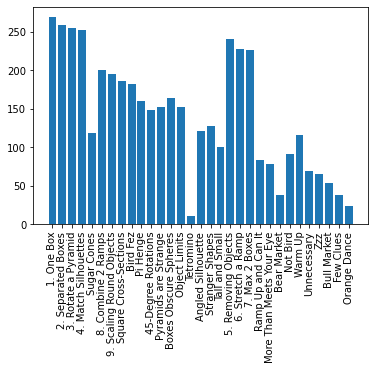

In [121]:
matrix = adaptedData(dataEvents)
matrix2 = []
puzzles_count = dict()

for a,b in matrix.iterrows():
    for kc in b["kc"].split("~"):
        if b["task_id"] not in puzzles_count:
            puzzles_count[b["task_id"]] = 1
        else:
            puzzles_count[b["task_id"]] += 1
            
        if((b["task_id"] in mg1Puzzles) and kc == 'MG.1'):
            matrix2.append([b["user"], b["task_id"], b[completed], kc, b["initial timestamp"]])
        elif((b["task_id"] in co6Puzzles) and kc == 'CO.6'):
            matrix2.append([b["user"], b["task_id"], b[completed], kc, b["initial timestamp"]])
        elif((b["task_id"] in co5Puzzles) and kc == 'CO.5'):
            matrix2.append([b["user"], b["task_id"], b[completed], kc, b["initial timestamp"]])
        elif((b["task_id"] in gmd4Puzzles) and kc == 'GMD.4'):
            matrix2.append([b["user"], b["task_id"], b[completed], kc, b["initial timestamp"]])  
        elif((b["task_id"] in mixPuzzles) and kc == 'MIX'):
            matrix2.append([b["user"], b["task_id"], b[completed], kc, b["initial timestamp"]])
            
matrix2 = pd.DataFrame(matrix2, columns = ["user_id", "task_id", "correct", "kc", "timestamp"])
print(f'matrix2: {matrix2}')
print(f'puzzles count: {puzzles_count}')
plt.bar(*zip(*puzzles_count.items()))
plt.xticks(rotation=90)
plt.show()

In [122]:
df1 = matrix2[['user_id', 'task_id', 'timestamp', 'correct', 'kc']]

df1["time2"] = pd.to_datetime(df1["timestamp"], utc=True)
df1['time3'] = [int(time.mktime(t.timetuple())) for t in df1["time2"]]
df1['timestamp'] = df1['time3'] - min(df1['time3'])

df1["correct"]= df1["correct"].apply(lambda x: int(x))

code, unique = df1["user_id"].factorize()
df1["user_id"] = code

code, unique = df1["task_id"].factorize()
df1["item_id"] = code
print(unique, code)

code, unique = df1["kc"].factorize()
df1["skill_name"] = code

code, unique = df1["kc"].factorize()
df1["skill_id"] = code

df1

Index(['1. One Box', '2. Separated Boxes', '3. Rotate a Pyramid',
       '4. Match Silhouettes', 'Sugar Cones', '8. Combine 2 Ramps',
       '9. Scaling Round Objects', 'Square Cross-Sections', 'Bird Fez',
       'Pi Henge', '45-Degree Rotations', 'Pyramids are Strange',
       'Boxes Obscure Spheres', 'Object Limits', 'Tetromino',
       'Stranger Shapes', 'Tall and Small', '5. Removing Objects',
       '6. Stretch a Ramp', '7. Max 2 Boxes', 'Ramp Up and Can It',
       'More Than Meets Your Eye', 'Bear Market', 'Not Bird', 'Warm Up',
       'Unnecessary', 'Zzz', 'Bull Market', 'Few Clues', 'Orange Dance'],
      dtype='object') [ 0  1  2 ... 17 18  0]


,user_id,task_id,timestamp,correct,kc,time2,time3,item_id,skill_name,skill_id
0,0,1. One Box,0,1,MIX,2019-09-09 17:29:30.215461+00:00,1568046570,0,0,0
1,0,2. Separated Boxes,32,1,MIX,2019-09-09 17:30:02.612859+00:00,1568046602,1,0,0
2,0,3. Rotate a Pyramid,98,1,MIX,2019-09-09 17:31:08.542014+00:00,1568046668,2,0,0
3,0,4. Match Silhouettes,350,0,MIX,2019-09-09 17:35:20.500391+00:00,1568046920,3,0,0
4,0,Sugar Cones,688,0,MIX,2019-09-09 17:40:58.696219+00:00,1568047258,4,0,0
...,...,...,...,...,...,...,...,...,...,...
4284,286,3. Rotate a Pyramid,7883007,1,MIX,2019-12-09 23:12:57.563347+00:00,1575929577,2,0,0
4285,286,4. Match Silhouettes,7883087,1,MIX,2019-12-09 23:14:17.112348+00:00,1575929657,3,0,0
4286,286,5. Removing Objects,7883132,1,MIX,2019-12-09 23:15:02.918883+00:00,1575929702,17,0,0
4287,286,6. Stretch a Ramp,7883236,1,CO.6,2019-12-09 23:16:46.831744+00:00,1575929806,18,4,4


In [123]:
bkt_preparation = df1[['user_id', 'skill_name', 'correct']]
bkt_preparation.to_csv(r'C:\\Users\\struk\\Downloads\\BKT_priorities\\preprocessed_data.csv', index = False, sep=",")

pfa_preparation = df1[['user_id', 'item_id', 'timestamp', 'correct', 'skill_id']]
pfa_preparation.to_csv(r'C:\\Users\\struk\\Downloads\\learner-performance-prediction-master\\data\\shadow_priorities\\preprocessed_data.csv', index = False, sep="\t")
assert(len(bkt_preparation) == len(pfa_preparation))

In [124]:
# Train-test split
train_split = 0.7
users = df1["user_id"].unique()
np.random.shuffle(users)
split = int(train_split * len(users))

In [125]:
train_df = bkt_preparation[bkt_preparation["user_id"].isin(users[:split])]
test_df = bkt_preparation[bkt_preparation["user_id"].isin(users[split:])]
train_df.to_csv(r'C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_train_preprocessed.csv', index = False, sep=",")
test_df.to_csv(r'C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_test_preprocessed.csv', index = False, sep=",")


train_df = pfa_preparation[pfa_preparation["user_id"].isin(users[:split])]
test_df = pfa_preparation[pfa_preparation["user_id"].isin(users[split:])]
train_df.to_csv(r'C:\\Users\\struk\\Downloads\\learner-performance-prediction-master\\data\\shadow_priorities\\preprocessed_data_train.csv', index = False, sep="\t")
test_df.to_csv(r'C:\\Users\\struk\\Downloads\\learner-performance-prediction-master\\data\\shadow_priorities\\preprocessed_data_test.csv', index = False, sep="\t")

In [126]:
# Build Q-matrix
Q_mat = np.zeros((pfa_preparation["item_id"].nunique(), pfa_preparation["skill_id"].nunique()))
for item_id, skill_id in pfa_preparation[["item_id", "skill_id"]].values:
    Q_mat[item_id][skill_id] = 1
    
sparse.save_npz(os.path.join('C:\\Users\\struk\\Downloads\\learner-performance-prediction-master\\data\\shadow_priorities', "q_mat.npz"), sparse.csr_matrix(Q_mat))

In [127]:
from pyBKT.models import Model

sys.path.append('../')
np.seterr(divide='ignore', invalid='ignore')

model = Model(seed = 0, num_fits = 20)
model.fit(data_path = "C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_train_preprocessed.csv", forgets=True)
auc_result = model.evaluate(data_path = "C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_test_preprocessed.csv", metric = 'auc')
accuracy_result = model.evaluate(data_path = "C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_test_preprocessed.csv", metric = 'accuracy')
f1_score_result = model.evaluate(data_path = "C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_test_preprocessed.csv", metric = 'f1_score')

print(f'AUC metric result of BKT algorithm: {auc_result}')
print(f'Accuracy result of BKT algorithm: {accuracy_result}')
print(f'F1 score result of BKT algorithm: {f1_score_result}')

AUC metric result of BKT algorithm: 0.749210087895674
Accuracy result of BKT algorithm: 0.868663594470046
F1 score result of BKT algorithm: 0.9294845360824742


In [113]:
model.fit(data_path = "C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_train_preprocessed.csv", forgets=True)
preds_df = model.predict(data_path = "C:\\Users\\struk\\Downloads\\BKT_priorities\\builder_test_preprocessed.csv")
preds_df

,user_id,skill_name,correct,correct_predictions,state_predictions
0,5,0,1,0.97454,0.04116
1,5,0,1,0.95422,0.11356
2,5,0,1,0.94035,0.16300
3,5,0,1,0.93054,0.19798
4,5,0,1,0.92341,0.22338
...,...,...,...,...,...
1311,284,2,0,0.80920,0.28752
1312,284,0,0,0.74206,0.86972
1313,284,0,1,0.70754,0.99274
1314,284,0,1,0.70833,0.98992


In [114]:
pred_bkt_priorities = preds_df[['user_id', 'correct_predictions']]
pred_bkt_priorities.to_csv(r'C:\\Users\\struk\\Downloads\\pred_bkt_priorities.csv', index = False, sep=",")